In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urljoin

# Function to fetch HTML content from a URL
def fetch_html_content(url):
    response = requests.get(url)
    return response.text

# Function to parse reviews from HTML content
def parse_reviews(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    reviews = soup.find_all('article', {'itemprop': 'review'})
    data = []

    for review in reviews:
        review_data = {}

        # Extract basic review information
        review_data['datePublished'] = review.find('meta', {'itemprop': 'datePublished'})['content'] if review.find('meta', {'itemprop': 'datePublished'}) else None
        review_data['ratingValue'] = review.find('span', {'itemprop': 'ratingValue'}).text.strip() if review.find('span', {'itemprop': 'ratingValue'}) else None
        review_data['bestRating'] = review.find('span', {'itemprop': 'bestRating'}).text.strip() if review.find('span', {'itemprop': 'bestRating'}) else None
        review_data['title'] = review.find('h2', {'class': 'text_header'}).text.strip() if review.find('h2', {'class': 'text_header'}) else None
        review_data['author'] = review.find('span', {'itemprop': 'name'}).text.strip() if review.find('span', {'itemprop': 'name'}) else None
        review_data['reviewBody'] = review.find('div', {'itemprop': 'reviewBody'}).text.strip() if review.find('div', {'itemprop': 'reviewBody'}) else None

        # Extract travel details
        review_data['typeOfTraveller'] = review.find('td', {'class': 'review-rating-header'}, text='Type Of Traveller').find_next_sibling('td', {'class': 'review-value'}).text.strip() if review.find('td', {'class': 'review-rating-header'}, text='Type Of Traveller') else None
        review_data['seatType'] = review.find('td', {'class': 'review-rating-header'}, text='Seat Type').find_next_sibling('td', {'class': 'review-value'}).text.strip() if review.find('td', {'class': 'review-rating-header'}, text='Seat Type') else None
        review_data['route'] = review.find('td', {'class': 'review-rating-header'}, text='Route').find_next_sibling('td', {'class': 'review-value'}).text.strip() if review.find('td', {'class': 'review-rating-header'}, text='Route') else None
        review_data['dateFlown'] = review.find('td', {'class': 'review-rating-header'}, text='Date Flown').find_next_sibling('td', {'class': 'review-value'}).text.strip() if review.find('td', {'class': 'review-rating-header'}, text='Date Flown') else None

        # Extract star ratings for categories
        categories = ['Value For Money', 'Seat Comfort', 'Cabin Staff Service', 
                      'Food & Beverages', 'Inflight Entertainment', 
                      'Ground Service', 'Wifi & Connectivity']
        for category in categories:
            rating_header = review.find('td', {'class': 'review-rating-header'}, text=category)
            if rating_header:
                stars = rating_header.find_next_sibling('td', {'class': 'review-rating-stars'}).find_all('span', {'class': 'star'})
                review_data[category.lower().replace(' ', '_')] = sum(1 for star in stars if 'fill' in star.get('class', []))
                review_data[category.lower().replace(' ', '_') + '_count'] = len(stars)
                review_data[category.lower().replace(' ', '_') + '_best_rating'] = max(int(star.text.strip()) for star in stars if 'fill' in star.get('class', []))

        # Extract Recommended
        recommended = review.find('td', {'class': 'review-rating-header'}, text='Recommended')
        review_data['recommended'] = recommended.find_next_sibling('td', {'class': 'review-value'}).text.strip().lower() == 'yes' if recommended else None

        # Extract Aircraft
        aircraft = review.find('td', {'class': 'review-rating-header'}, text='Aircraft')
        review_data['aircraft'] = aircraft.find_next_sibling('td', {'class': 'review-value'}).text.strip() if aircraft else None

        data.append(review_data)

    return data

# Function to extract pagination links
def extract_pagination_links(html_content, base_url):
    soup = BeautifulSoup(html_content, 'html.parser')
    pagination = soup.find('article', class_='comp_reviews-pagination')
    if pagination:
        page_links = pagination.find_all('a', href=True)
        unique_links = set(urljoin(base_url, link['href']) for link in page_links)
        return list(unique_links)
    return []

# Function to extract total number of pages
def extract_total_pages(pagination_links):
    return max(int(link.rsplit('/', 2)[-2]) for link in pagination_links if link.rsplit('/', 2)[-2].isdigit())

# URL of the British Airways review page on Airline Quality
base_url = 'https://www.airlinequality.com'
url = 'https://www.airlinequality.com/airline-reviews/british-airways'

# Fetch HTML content of the main review page
html_content = fetch_html_content(url)

# Extract pagination links from the main review page
pagination_links = extract_pagination_links(html_content, base_url)

# Determine the total number of pages from pagination links
total_pages = extract_total_pages(pagination_links)
print(f"Total Number of Pages: {total_pages}")

# Iterate through each page and extract reviews
all_reviews_data = []
for page_num in range(1, total_pages + 1):
    page_url = f"{base_url}/airline-reviews/british-airways/page/{page_num}/"
    print(f"Extracting reviews from page {page_num}...")

    # Fetch HTML content for the current page
    page_html_content = fetch_html_content(page_url)

    # Parse reviews from the HTML content
    page_reviews_data = parse_reviews(page_html_content)

    # Append reviews data to the list
    all_reviews_data.extend(page_reviews_data)

# Convert extracted data to a DataFrame
df = pd.DataFrame(all_reviews_data)

# Display the DataFrame
print("\nDataFrame:")
print(df.head())  # Displaying first few rows for demonstration


# Save files to CSV

In [ ]:
df.to_csv('C:\\Users\\mango\\OneDrive\\Desktop\\Data Analytics Projects\\Britist\\british_airways_reviews.csv', index=False)
print("Data saved to 'british_airways_reviews.csv'")

In [67]:
# Import necessary libraries
import pandas as pd

# Load the data
file_path = "C:\\Users\\mango\\OneDrive\\Desktop\\Data Analytics Projects\\Britist\\british_airways_reviews.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
# print(df.head())

# Specify the columns to keep
columns_to_keep = ['datePublished', 'ratingValue', 'reviewBody']

# Create a new DataFrame with only the specified columns
df_filtered = df[columns_to_keep]
print(df_filtered.head())


  datePublished  ratingValue  \
0    2024-07-05          1.0   
1    2024-07-01          1.0   
2    2024-06-30          1.0   
3    2024-06-26          6.0   
4    2024-06-23          3.0   

                                          reviewBody  
0  Not Verified | The WORST customer experience! ...  
1  Not Verified |   Had to cancel my flight month...  
2  ✅ Trip Verified | Flight cancelled with no rea...  
3  ✅ Trip Verified | This is a route I fly regula...  
4  ✅ Trip Verified |  While BA may have made some...  


In [68]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stopwords dataset
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Get the standard list of stopwords
stop_words = set(stopwords.words('english'))
# print(stop_words)

# Get the standard list of stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = set(["not", "trip","verified", "airways", "british", "ba"])
stop_words.update(custom_stopwords)

# Print the extended stopwords list
# print(stop_words)

# Clean the text by removing non-word characters and converting to lowercase
def clean_text(text):
    text = re.sub(r'\W+', ' ', str(text))
    text = text.lower().strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply clean_text to the reviewBody column
df_filtered['cleaned_review'] = df_filtered['reviewBody'].apply(clean_text)
print(df_filtered[['reviewBody', 'cleaned_review']].head())


                                          reviewBody  \
0  Not Verified | The WORST customer experience! ...   
1  Not Verified |   Had to cancel my flight month...   
2  ✅ Trip Verified | Flight cancelled with no rea...   
3  ✅ Trip Verified | This is a route I fly regula...   
4  ✅ Trip Verified |  While BA may have made some...   

                                      cleaned_review  
0  worst customer experience effectively robbing ...  
1  cancel flight months advance due change schedu...  
2  flight cancelled reason given less 24 h depart...  
3  route fly regularly used first class security ...  
4  may made positive improvements club world prod...  


C:\Users\mango\AppData\Local\Temp\ipykernel_7772\1362971653.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cleaned_review'] = df_filtered['reviewBody'].apply(clean_text)


C:\Users\mango\AppData\Local\Temp\ipykernel_7772\832527495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['text_sentiment'] = df_filtered['cleaned_review'].apply(get_sentiment)
C:\Users\mango\AppData\Local\Temp\ipykernel_7772\832527495.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment_category'] = df_filtered['text_sentiment'].apply(categorize_sentiment)


                                      cleaned_review  text_sentiment
0  worst customer experience effectively robbing ...        0.004861
1  cancel flight months advance due change schedu...        0.168750
2  flight cancelled reason given less 24 h depart...       -0.424074
3  route fly regularly used first class security ...        0.265686
4  may made positive improvements club world prod...       -0.075384


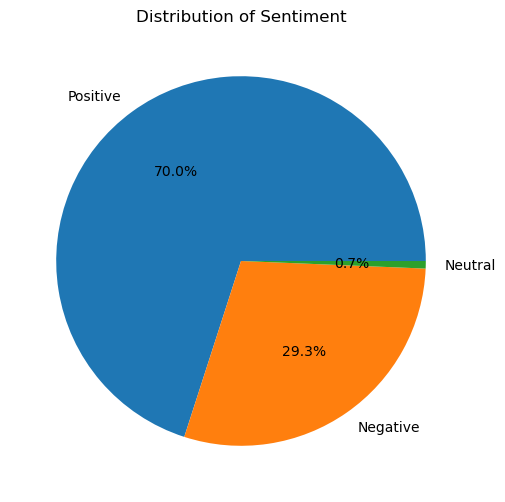

In [70]:
from textblob import TextBlob

# Define the get_sentiment function
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply get_sentiment to the cleaned_review column
df_filtered['text_sentiment'] = df_filtered['cleaned_review'].apply(get_sentiment)
print(df_filtered[['cleaned_review', 'text_sentiment']].head())

# Categorize the sentiment
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'
    


df_filtered['sentiment_category'] = df_filtered['text_sentiment'].apply(categorize_sentiment)

# Display the distribution of sentiment categories
sentiment_counts = df_filtered['sentiment_category'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Sentiment')
plt.savefig('sentiment_category_distribution_percentage_pie.png')
plt.show()



C:\Users\mango\AppData\Local\Temp\ipykernel_7772\2353311810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = pd.to_datetime(df_filtered['datePublished']).dt.year


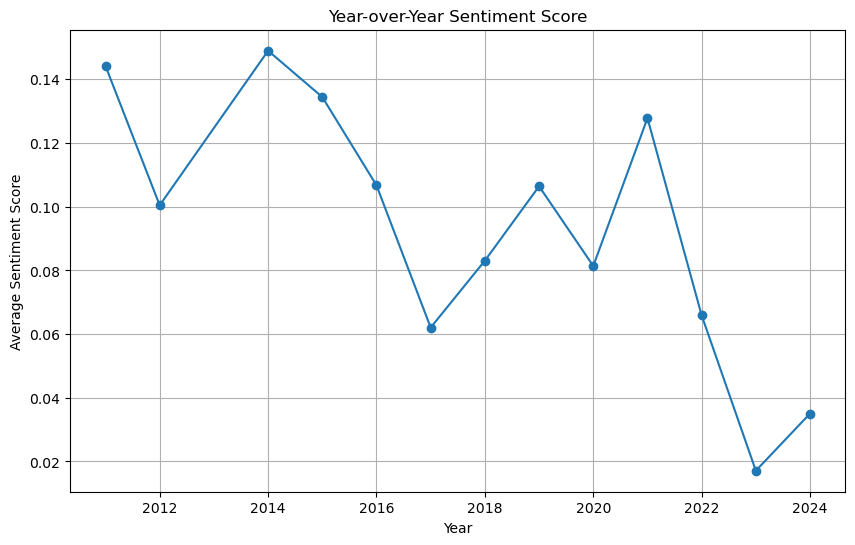

In [76]:
# Extract year from date and aggregate sentiment scores by year
df_filtered['year'] = pd.to_datetime(df_filtered['datePublished']).dt.year
yearly_sentiment = df_filtered.groupby('year')['text_sentiment'].mean().reset_index()

# Plot the year-over-year sentiment trend
plt.figure(figsize=(10, 6))
plt.plot(yearly_sentiment['year'], yearly_sentiment['text_sentiment'], marker='o')
plt.title('Year-over-Year Sentiment Score')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()




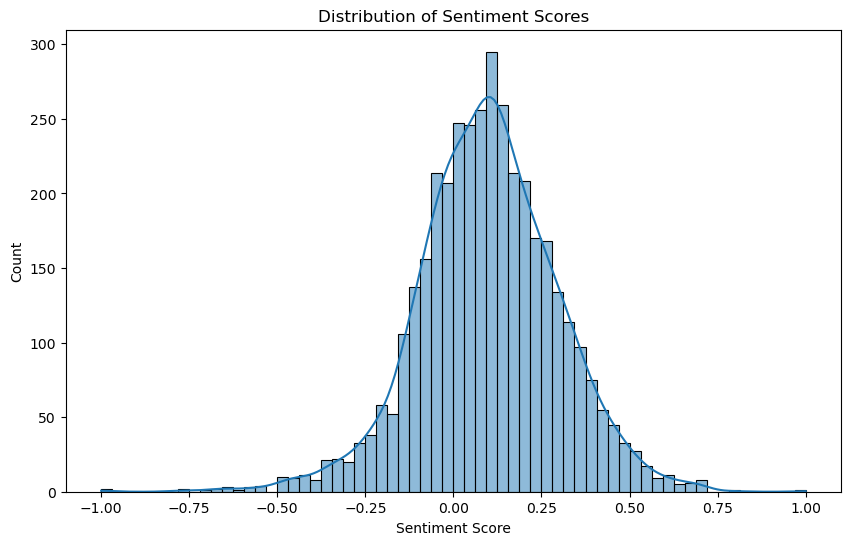

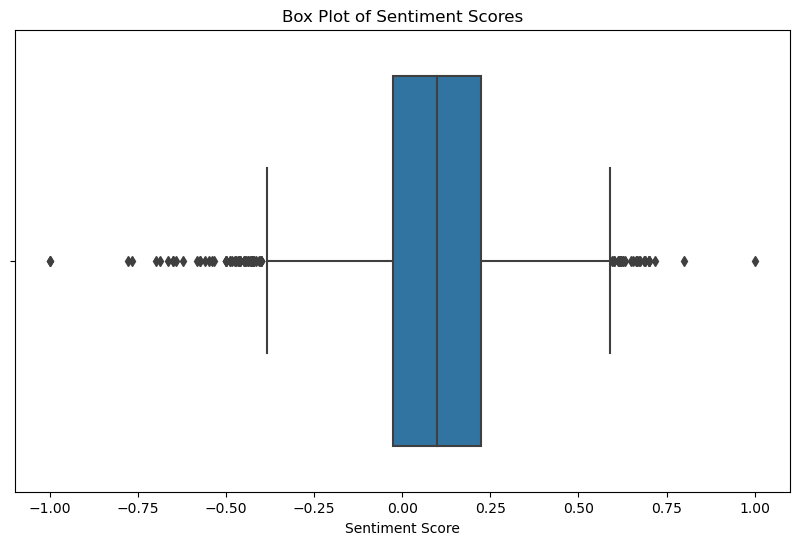

Sentiment Score Analysis:
Mean Sentiment Score: 0.0977
Median Sentiment Score: 0.0978
Standard Deviation: 0.1988
Minimum Sentiment Score: -1.0000
Maximum Sentiment Score: 1.0000
First Quartile (Q1): -0.0253
Third Quartile (Q3): 0.2222
Interquartile Range (IQR): 0.2475


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_filtered is the DataFrame containing the sentiment scores
# and 'text_sentiment' is the column with the sentiment scores

# Create a histogram of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['text_sentiment'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.savefig('sentiment_distribution.png')
plt.show()

# Create a box plot of sentiment scores
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_filtered['text_sentiment'])
plt.title('Box Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.savefig('sentiment_boxplot.png')
plt.show()

# Print details about the sentiment scores
mean_score = df_filtered['text_sentiment'].mean()
median_score = df_filtered['text_sentiment'].median()
std_dev = df_filtered['text_sentiment'].std()
min_score = df_filtered['text_sentiment'].min()
max_score = df_filtered['text_sentiment'].max()
q1 = df_filtered['text_sentiment'].quantile(0.25)
q3 = df_filtered['text_sentiment'].quantile(0.75)
iqr = q3 - q1

print("Sentiment Score Analysis:")
print(f"Mean Sentiment Score: {mean_score:.4f}")
print(f"Median Sentiment Score: {median_score:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Minimum Sentiment Score: {min_score:.4f}")
print(f"Maximum Sentiment Score: {max_score:.4f}")
print(f"First Quartile (Q1): {q1:.4f}")
print(f"Third Quartile (Q3): {q3:.4f}")
print(f"Interquartile Range (IQR): {iqr:.4f}")


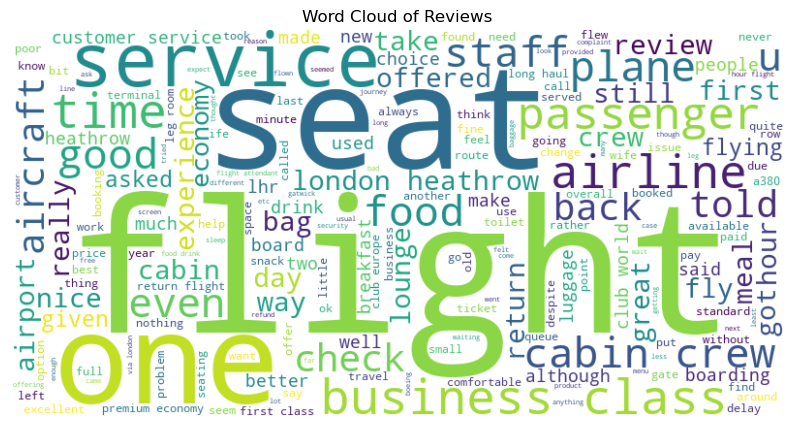

In [48]:
from wordcloud import WordCloud
# Word cloud


# Create a word cloud of the cleaned reviews
text_combined = ' '.join(df_filtered['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.savefig('word_cloud.png')
plt.show()